### Group Members:

- Hangchen Xie, 22-736-789
- Yanyang Gong, 23-744-063
- Yaojie Wang, 23-741-283

# Assignment 8: Open-Set Classification

In this assignment, we develop a network that is capable of correctly classifying known classes while at the same time rejecting unknown samples that occur during inference time.
To showcase the capability, we make use of the MNIST dataset that we artificially split into known and unknown classes; this allows us to train a network on the data without requiring too expensive hardware.


We select the MNIST dataset and define several classes to be known, negative class during training, and unknown (not used for training at all).

## Dataset
We split the MNIST dataset into 4 known classes, 4 negative classes (used for training) and 2 unknown classes (used only for testing).
While several splits might be possible, here we restrict to the following:
* Known class indexes: (1, 4, 5, 8)
* negative class indexes: (0, 2, 3, 7)
* Unknown class indexes: (6,9)

Please note that, in PyTorch, class indexing starts at 0 (other than in the lecture where class indexing starts at 1).

We rely on the `torchvision.datasets.MNIST` implementation of the `MNIST` dataset, which we adapt to our needs.
The constructor of our Dataset class takes one parameter that defines the purpose of this dataset (`"train", "validation", "test"`).
The `"train"` partition uses the training samples of the *known* and the *negative* classes.
The `"validation"` partition uses the test samples of the *known* and the *negative* classes.
Finally, the `"test"` partition uses the test samples of the *known* and the *unknown* classes.

In our implementation of the Dataset class, we need to implement two functions.
* First, the constructor `__init__(self, purpose)` selects the data based on our purpose.
* Second, the index function `__getitem__(self, n)` returns a pair $(X^n, \vec t^n)$ for the sample with the index $n$, where $X \in \mathbb R^{1\times28\times28}$ with values in range $[0,1]$ and $\vec t \in \mathbb R^{O}$, see below.

Since our loss function (cf. Task 5) requires our target vectors to be in vector format, we need to convert the target index $t^n$ into its vector representation $\vec t^n$.
Particularly, we need to provide the following target vectors:

<center>

 $\vec t^n = 1 : \vec t^n = (1,0,0,0)$

 $\vec t^n = 4 : \vec t^n = (0,1,0,0)$

 $\vec t^n = 5 : \vec t^n = (0,0,1,0)$

 $\vec t^n = 8 : \vec t^n = (0,0,0,1)$

 else: $\vec t^n = (\frac14,\frac14,\frac14,\frac14)$

</center>


### Task 1: Target Vectors

Implement a function that generates a target vector for any of the ten different classes according to above description. The return value should be a `torch.tensor` of type float.

In [1]:
import torch
import torchvision

# define the three types of classes
known_classes = (1, 4, 5, 8)
negative_classes = (0, 2, 3, 7)
unknown_classes = (6, 9)
O = len(known_classes)

# define one-hot vectors
labels_known = torch.eye(O)
label_unknown = torch.ones(1, O) / O

def target_vector(index):
  # select correct one-hot vector for known classes, and the 1/O-vectors for unknown classes
    if index in known_classes:
        return labels_known[known_classes.index(index)]
    else:
        return label_unknown[0]

### Test 1: Check your Target Vectors

Test that your target vectors are correct, for all tpyes of known and unknown samples.


In [2]:
# check that the target vectors for known classes are correct
for index in known_classes:
  t = target_vector(index)
  print(index, t)
  assert max(t) == 1
  assert sum(t) == 1

# check that the target vectors for unknown classes are correct
for index in negative_classes + unknown_classes:
  t = target_vector(index)
  print(index, t)
  assert max(t) == 0.25
  assert sum(t) == 1


1 tensor([1., 0., 0., 0.])
4 tensor([0., 1., 0., 0.])
5 tensor([0., 0., 1., 0.])
8 tensor([0., 0., 0., 1.])
0 tensor([0.2500, 0.2500, 0.2500, 0.2500])
2 tensor([0.2500, 0.2500, 0.2500, 0.2500])
3 tensor([0.2500, 0.2500, 0.2500, 0.2500])
7 tensor([0.2500, 0.2500, 0.2500, 0.2500])
6 tensor([0.2500, 0.2500, 0.2500, 0.2500])
9 tensor([0.2500, 0.2500, 0.2500, 0.2500])


### Tasks 2 and 3: Dataset Construction and Dataset Item Selection

Write a dataset class that derives from `torchvision.datasets.MNIST` in `PyTorch` and adapts some parts of it.
In the constructor, make sure that you let `PyTorch` load the dataset by calling the base class constructor `super` with the desired parameters. Afterward, the `self.data` and `self.targets` are populated with all samples and target indexes.
From these, we need to sub-select the samples that fit our current `purpose` and store them back to `self.data` and `self.targets`.

Second, we need to implement the index function of our dataset, where we need to return both the image and the target vector.
The images in `self.data` were originally stored as `uint8` values in the dimension $\mathbb N^{N\times28\times28}$ with values in $[0, 255]$.
The targets in `self.targets` were originally stored as class indexes in the dimension $\mathbb N^N$. Make sure that you return both in the desired format.

Notes:

* Since Jupyter Notebook does not allow splitting classes over several code boxes, the two tasks are required to be solved in the same code box.
* **The definition below is just one possibility.** There are many ways to implement this dataset interface.
* With a clever implementation of the constructor, there is no need to overwrite the `__getitem__(self,index)` function.
* Depending on your implementation, you might also need to overwrite the `__len__(self)` function.

In [3]:
class DataSet(torchvision.datasets.MNIST):
  def __init__(self, purpose="train"):
    # call base class constructor to handle the data loading
    # make sure that you get the correct part of the data based on the purpose

    super(DataSet, self).__init__(
        root='./data',
        train=True if purpose == "train" else False,
        download=True,
        transform=torchvision.transforms.ToTensor()
      )

    # select the valid classes based on the current purpose
    if purpose == "train" or purpose == "validation":
      valid_classes = known_classes + negative_classes
    else:
      valid_classes = known_classes + unknown_classes
    # select the samples that belong to these classes
    indexes = [i for i in range(len(self.targets)) if self.targets[i] in valid_classes]
    self.data = self.data[indexes]
    # sub-select the data of valid classes
    self.targets = self.targets[indexes]
    # select the targets of valid classes, and already turn them into target vectors
    self.targets = torch.stack([target_vector(t) for t in self.targets])

  def __getitem__(self, index):
    # perform appropriate actions on the data and the targets
    # the format of data should be in [0, 1]

    input = (self.data[index].float() / 255).unsqueeze(0)

    target = self.targets[index]
    return input, target

### Test 2: Data Sets


Instantiate the training dataset.
Implement a data loader for the training dataset with a batch size of 64.
Assure that all inputs are of the desired type and shape.
Assert that the target values are in the correct format, and the sum of the target values per sample is one.


In [4]:
# instantiate the training dataset

train_set = DataSet(purpose="train")
train_loader = torch.utils.data.DataLoader(train_set, 64, shuffle=True)

# assert that we have not filtered out all samples
assert len(train_set)!= 60000 and len(train_set)== 48133

# check the batch and assert valid data and sizes
for x,t in train_loader:
  assert len(x) <= 64
  assert len(t) == len(x)
  assert torch.all(torch.sum(t, axis = 1) == 1)
  assert x.shape == torch.Size([x.shape[0], 1, 28, 28])
  assert x.dtype == torch.float32
  assert torch.max(x) <= 1
  assert torch.min(x) >= 0

### Task 4: Data Loader

Call the dataset class sperately with batch size of $B=256$, and instantiate data loaders for the three datasets.


In [5]:
batch_size = 256

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# instantiate training dataset and data loader
train_set = DataSet(purpose="train")
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)

# instantiate validation set and data loader
validation_set = DataSet(purpose="validation")
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size, shuffle=False)

# instantiate test set and according data loader
test_set = DataSet(purpose="test")
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)


### Task 5: Utility Function

Implement a function that splits a batch of samples into known and unknown parts. For the known parts, also provide the target vectors.
How can we know which of the data samples are known samples, and which are unknown?

This function needs to return three elements:
* First, the samples from the batch that belong to known classes.
* Second, the target vectors that belong to the known classes.
* Finally, the samples from the batch that belong to unknown classes.


In [6]:
def split_known_unknown(batch, targets):
  # select the indexes at which known and unknown samples exist
  known = torch.any(targets == 1, dim=1)
  unknown = ~known
  # return the known samples, the targets of the known samples, as well as the unknown samples
  return batch[known], targets[known], batch[unknown]

## Loss Function and Confidence

We write our own PyTorch implementation of our loss function.
Particularly, we implement a manual way to define the derivative of our loss function via `torch.autograd.Function`, which allows us to define the forward and backward pass on our own.
For this purpose, we need to implement two `static` functions in our loss.
The function `forward(ctx, logits, targets)` is required to compute the loss value and allows us to store some variables in the context of the backward pass.
The `backward(ctx, result)` provides us with the result of the forward function (the loss value) as well as the context with our stored variables.
Here, we need to compute the derivative of the loss with respect to both of the inputs to the forward function (which might look a bit confusing), i.e.,$\frac{\partial \mathbf{J}^{CCE}}{\partial \mathbf{Z}}$ and $\frac{\partial \mathbf{J}^{CCE}}{\partial \mathbf{T}}$.
Since the latter is not required, we can also simply return `None` for the second derivative.

<font color=#FF000>Hint: if you think the implementation of loss function is too hard, you can also cross-entropy as your loss function (**since PyTorch version 1.11**).</font>

### Task 6: Loss Function Implementation

Implement a `torch.autograd.Function` class for the adapted SoftMax function according to the equations provided in the lecture.
You might want to compute the log of the network output $\ln y_o$ from the logits $z_o$ via `torch.nn.functional.log_softmax`.
Store all the data required for the backward pass in the context during `forward`, and extract these from the context during `backward`.

In [7]:
class AdaptedSoftMax(torch.autograd.Function):

  # implement the forward propagation
  @staticmethod
  def forward(ctx, logits, targets):
    # compute the log probabilities via log_softmax
    log_probs = torch.nn.functional.log_softmax(logits, dim=1)
    # save required values for backward pass
    ctx.save_for_backward(logits, targets)
    # compute loss
    loss = -torch.sum(log_probs * targets, dim=1).mean()
    return loss

  # implement Jacobian
  @staticmethod
  def backward(ctx, result):
    # get results stored from forward pass
    logits, targets = ctx.saved_tensors
    # compute derivative of loss w.r.t. the logits
    y = torch.nn.functional.softmax(logits, dim=1)
    dJ_dz = result * (y - targets)
    # return the derivatives; none for derivative for the targets
    return dJ_dz, None

# DO NOT REMOVE!
# here we set the adapted softmax function to be used later
adapted_softmax = AdaptedSoftMax.apply

### Task 6a: Alternative Loss Function

In case the loss function is too difficult to implement, you can also choose to rely on PyTorch's automatic gradient computation and simply define your loss function without the backward pass.

In this case, we only need to define the forward pass. A simple function `adapted_softmax(logits, targets)` is sufficient.

You can implement any variant of the categorical cross-entropy loss function on top of SoftMax activations as defined in the lecture.


In [8]:
def adapted_softmax_alt(logits, targets):
  # compute cross-entropy loss on top of softmax values of the logits
  return torch.nn.functional.cross_entropy(logits, torch.argmax(targets, dim=1))


### Task 7: Confidence Evaluation

Implement a function to compute the confidence value for a given batch of samples. 
Compute Softmax confidence and split these confidences between known and unknown classes. 
For samples from known classes, sum up the SoftMax confidences of the correct class. 
For unknown samples, sum 1 minus the maximum confidence for any of the known classes; also apply the $\frac1O$ correction for the minimum possible SoftMax confidence.

In [9]:
def confidence(logits, targets):
 
  # compute softmax confidences
  conf = torch.nn.functional.softmax(logits, dim=1)

  # split between known and unknown
  known, targets_know, unknown = split_known_unknown(conf, targets)
  # compute confidence score for known targets
  conf_known = torch.sum(known * targets_know)
  # compute confidence score for unknown targets
  conf_unknown = torch.sum(1 - torch.max(unknown, dim=1)[0] + 1/O)

  return conf_known + conf_unknown

### Test 3: Check Confidence Implementation

Test that your confidence implementation does what it is supposed to do.

Note that confidence values should always be between 0 and 1, other values indicate an issue in the implementation.

In [10]:
# select good logit vectors for known and unknown classes
logits = torch.tensor([[10., 0., 0., 0.], [-10., 0, -10., -10.], [0.,0.,0.,0.]])
# select the according target vectors for these classes
targets = torch.stack([target_vector(known_classes[0]), target_vector(known_classes[1]), target_vector(negative_classes[0])])

# the confidence should be close to 1 for all cases
# calculate confidence
assert 3 - confidence(logits, targets) < 1e-3

## Network and Training

We make use of the same convolutional network as utilized in Assignment 6, to which we append a final fully-connected layer with $K$ inputs and $O$ outputs.
Additionally, we replace the $\sigma$ activation function with the better-performing **PReLU** function.

The topology can be found in the following:
1. 2D convolutional layer with $Q_1$ channels, kernel size $7\times7$, stride 1 and padding 0
2. 2D maximum pooling layer with kernel size $2\times2$ and stride 2
3. activation function **PReLU**
4. 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2
5. 2D maximum pooling layer with kernel size $2\times2$ and stride 2
6. activation function **PReLU**
7. flatten layer to convert the convolution output into a vector
8. fully-connected layer with the correct number of inputs and $K$ outputs
9. fully-connected layer with $K$ inputs and $O$ outputs



However, instead of relying on the `torch.nn.Sequential` class, we need to define our own network class, which we need to derive from `torch.nn.Module` -- since our network has two outputs.
We basically need to implement two methods in our network.
The constructor `__init__(self, Q1, Q2, K)` needs to call the base class constructor and initialize all required layers of our network.
The `forward(self, x)` function then passes the input through all of our layers and returns both the deep features (extracted at the first fully-connected layer) and the logits (extracted from the second fully-connected layer).


### Task 8: Network Definition

We define our own small-scale network to classify known and unknown samples for MNIST.

However, this time we need to implement our own network model since we need to modify our network output.

Implement a network class, including the layers as provided above.
Implement both the constructor and the forward function.
Instantiate the network with $Q_1=32, Q_2=32, K=20, O=4$.


In [11]:
class Network (torch.nn.Module):
  def __init__(self, Q1, Q2, K, O):
    # call base class constrcutor
    super(Network,self).__init__()
    # define convolutional layers
    self.conv1 = torch.nn.Conv2d(1, Q1, 7, stride=1, padding=0)
    self.conv2 = torch.nn.Conv2d(Q1, Q2, 5, stride=1, padding=2)
    # pooling and activation functions will be re-used for the different stages
    self.pool = torch.nn.MaxPool2d(2, stride=2)
    self.act = torch.nn.PReLU()
    # define fully-connected layers
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(Q2*5*5, K)
    self.fc2 = torch.nn.Linear(K, O)

  def forward(self,x):
    # compute first layer of convolution, pooling and activation
    a = self.act(self.pool(self.conv1(x)))
    # compute second layer of convolution, pooling and activation
    a = self.act(self.pool(self.conv2(a)))
    # get the deep features as the output of the first fully-connected layer
    deep_features = self.fc1(self.flatten(a))
    # get the logits as the output of the second fully-connected layer
    logits = self.fc2(deep_features)
    # return both the logits and the deep features
    return logits, deep_features

### Task 9: Training Loop

Implement a function for training network, which contains the training and validation loop. 
Compute the training set confidence during the epoch.
At the end of each epoch, also compute the validation set confidence measure.
Print both the training set and validation set confidence scores to the console. 
Finally, return the trained network.

In [12]:
def train(network,epochs, eta, momentum, loss_function):

  # Set GPU
  network = network.to(device)

  # SGD optimizer with appropriate learning rate
  optimizer = torch.optim.SGD(network.parameters(), lr=eta, momentum=momentum)

  for epoch in range(epochs):
    # evaluate average confidence for training and validation set
    train_conf = validation_conf = 0.

    for x,t in train_loader:

      # extract logits (and deep features) from network
      x = x.to(device)
      t = t.to(device)
      logits, _ = network(x)
      
      # compute loss
      loss = loss_function(logits, t)
      # perform weight update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training confidence
      train_conf += confidence(logits, t).item()

    # compute validation comfidence
    with torch.no_grad():
      for x,t in validation_loader:
        # extract logits (and deep features)
        x = x.to(device)
        t = t.to(device)
        logits, _ = network(x)
        # compute validation confidence
        validation_conf += confidence(logits, t).item()
    # print average confidence for training and validation
    print(f"\rEpoch {epoch}; train: {train_conf/len(train_set):1.5f}, val: {validation_conf/len(validation_set):1.5f}")

  return network

### Task 10: Network training

Instantiate network with $K1=K2=32$, $K=20$ and $O = 4$. Train the network for 30 epochs with an appropriate learning rate (the optimal learning rate might depend on your loss function implementation and can vary between 0.1 and 0.00001), momentum=$0.9$, and call the function you defined in Task 9.

In [17]:
loss_function = adapted_softmax
network_adapted = Network(32, 32, 20, 4)
network_adapted = train(network_adapted, 30, 1e-4, 0.9, loss_function)

Epoch 0; train: 0.77775, val: 0.83907
Epoch 1; train: 0.88238, val: 0.88894
Epoch 2; train: 0.90957, val: 0.92427
Epoch 3; train: 0.92526, val: 0.93354
Epoch 4; train: 0.93396, val: 0.93939
Epoch 5; train: 0.94128, val: 0.94211
Epoch 6; train: 0.94567, val: 0.94316
Epoch 7; train: 0.94865, val: 0.95196
Epoch 8; train: 0.95126, val: 0.95263
Epoch 9; train: 0.95418, val: 0.95443
Epoch 10; train: 0.95589, val: 0.95543
Epoch 11; train: 0.95765, val: 0.95798
Epoch 12; train: 0.95906, val: 0.95477
Epoch 13; train: 0.96020, val: 0.95643
Epoch 14; train: 0.96181, val: 0.96309
Epoch 15; train: 0.96312, val: 0.96188
Epoch 16; train: 0.96416, val: 0.96527
Epoch 17; train: 0.96534, val: 0.96399
Epoch 18; train: 0.96612, val: 0.96148
Epoch 19; train: 0.96734, val: 0.96391
Epoch 20; train: 0.96816, val: 0.96501
Epoch 21; train: 0.96855, val: 0.96398
Epoch 22; train: 0.96911, val: 0.96740
Epoch 23; train: 0.96996, val: 0.96811
Epoch 24; train: 0.97086, val: 0.96576
Epoch 25; train: 0.97116, val: 0.96

## Evaluation

For evaluation, we test two different things.
First, we check whether our intuition is correct, and the training helps reduce the deep feature magnitudes of unknown samples while maintaining magnitudes for known samples.
It is also interesting to see whether there is a difference between samples of the negative classes that were seen during training, and unknown classes that were not.
For this purpose, we extract the deep features for the validation and test sets, compute their magnitudes, and plot them in a histogram.

The second evaluation computes Correct Classification Rates (CCR) and False Positive Rates (FPR) for a given confidence threshold $\zeta=0.98$ (based on your training results, you might want to vary this threshold).
For the known samples, we compute how often the correct class was classified with a confidence over threshold.
For unknown samples, we assess how often one of the known classes was predicted with a confidence larger than $\zeta$.

### Task 11: Feature Magnitude Plot

Define a function, which can extract deep features for validation and test set samples and compute their magnitudes. Split them into known, negative (validation set), and unknown (test set). Plot a histogram for each of the three types of samples.
Note that the minimum magnitude is 0, and the maximum magnitude can depend on your network training success.

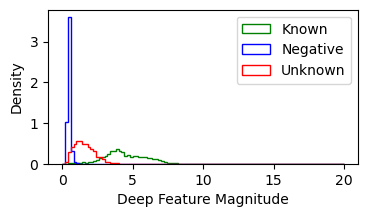

In [18]:
def plot_features(network):
    # collect feature magnitudes for
    known, negative, unknown = [], [], []

    with torch.no_grad():
        # extract deep features magnitudes for validation set
        for x,t in validation_loader:
            x = x.to(device)
            t = t.to(device)
            # extract deep features (and logits)
            logits, deep_features = network(x)
            # compute norms
            norms = torch.norm(deep_features, dim=1)
            # split between known and unknown
            known_samples, _, unknown_samples = split_known_unknown(norms, t)
            # collect norms of known samples
            known.extend(known_samples.cpu().numpy())
            # collect norms of negative samples
            negative.extend(unknown_samples.cpu().numpy())

        for x,t in test_loader:
            x = x.to(device)
            t = t.to(device)
            # extract deep features (and logits)
            logits, deep_features = network(x)
            # compute norms
            norms = torch.norm(deep_features, dim=1)
            # split between known and unknown
            known_samples, _, unknown_samples = split_known_unknown(norms, t)
            # collect norms of known samples
            known.extend(known_samples.cpu().numpy())
            # collect norms of unknown samples
            unknown.extend(unknown_samples.cpu().numpy())

    # plot the norms as histograms
    from matplotlib import pyplot
    pyplot.figure(figsize=(4,2))

    # keep the same maximum magnitude
    max_mag = 20
    # plot the three histograms
    pyplot.hist(known, bins=100, range=(0,max_mag), density=True, color="g", histtype="step", label="Known")
    pyplot.hist(negative, bins=100, range=(0,max_mag), density=True, color="b", histtype="step", label="Negative")
    pyplot.hist(unknown, bins=100, range=(0,max_mag), density=True, color="r", histtype="step", label="Unknown")

    # beautify plot
    pyplot.legend()
    pyplot.xlabel("Deep Feature Magnitude")
    pyplot.ylabel("Density")

plot_features(network_adapted)

### Task 12: Classification Evaluation

For a fixed threshold of $\zeta=0.98$, compute CCR and FPR for the test set.
A well-trained network can achieve a CCR of > 90% for an FPR < 10%.
You might need to vary the threshold.

In [19]:
def evaluation(network):
    zeta = 0.98

    # count the correctly classified and the total number of known samples
    correct = known = 0
    # count the incorrectly classified and the total number of unknown samples
    false = unknown = 0

    with torch.no_grad():
        for x,t in test_loader:
            x = x.to(device)
            t = t.to(device)
            # extract logits (and deep features)
            logits, _ = network(x)
            # compute softmax confidences
            conf = torch.nn.functional.softmax(logits, dim=1)

            # split between known and unknown
            known_samples, targets_known, unknown_samples = split_known_unknown(conf, t)

            # compute number of correctly classified knowns above threshold
            predictions = torch.argmax(known_samples, dim=1)
            targets = torch.argmax(targets_known, dim=1)
            correct_predictions = predictions == targets
            correct += torch.sum(correct_predictions & (torch.max(known_samples, dim=1).values > zeta)).item()
            known += len(known_samples)

            # compute number of incorrectly accepted known samples
            false += torch.sum(torch.max(unknown_samples, dim=1).values > zeta).item()
            unknown += len(unknown_samples)

    # print both rates
    print (f"CCR: {correct} of {known} = {correct/known*100:2.2f}%")
    print (f"FPR: {false} of {unknown} = {false/unknown*100:2.2f}%")

evaluation(network_adapted)

CCR: 3732 of 3983 = 93.70%
FPR: 125 of 1967 = 6.35%
